In [ ]:
import re
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random, cv2


def read_log_file(path):
    with open(path, "r") as file:
        log_lines = file.readlines()
    return log_lines


def extract_data(log_lines, pattern):
    results = []
    for line in log_lines:
        match = re.match(pattern, line)
        if match:
            results.append(match.group(1))
    return results

In [13]:
def pre_gen_loss(log_lines):
    pattern = r"(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3} - )?(\d+)/\d+: loss = (\d+\.\d+), PSNR = (\d+\.\d+)"
    results = [[],[],[]]

    for line in log_lines:
        match = re.match(pattern, line)
        if match:
            results[0].append(int(match.group(2)))
            results[1].append(float(match.group(3)))
            results[2].append(float(match.group(4)))
    return results


def gan_loss(log_lines):
    pattern = r"(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3} - )?(\d+)/\d+, perceptual loss = (\d+\.\d+), discriminator loss = (\d+\.\d+)"
    results = [[],[],[]]

    for line in log_lines:
        match = re.match(pattern, line)
        if match:
            results[0].append(int(match.group(2)))
            results[1].append(float(match.group(3)))
            results[2].append(float(match.group(4)))
    return results    

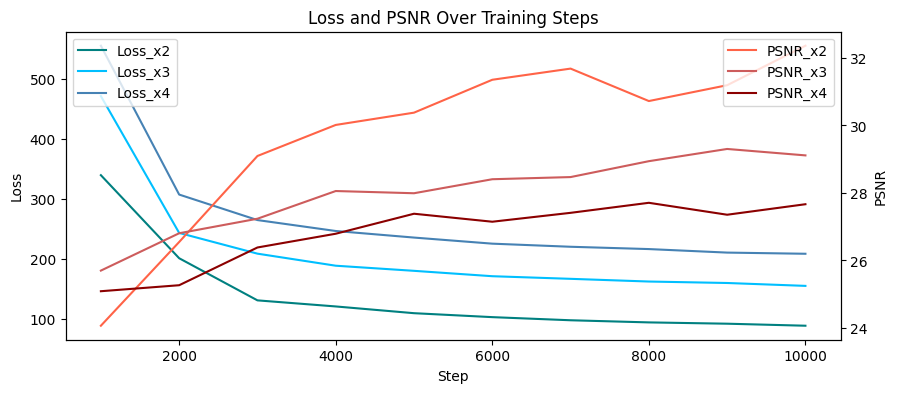

In [16]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
par = ax.twinx()
loss_color = ['#008080', '#00BFFF', '#4682B4']
psnr_color = ['#FF6347', '#CD5C5C', '#8B0000']
for i in range(2, 5):
    log_file = f'results/training_x{i}.log'
    log_lines = read_log_file(log_file)
    results = pre_gen_loss(log_lines)
    ax.plot(results[0], results[1], color=loss_color[i-2], label=f'Loss_x{i}')
    par.plot(results[0], results[2], color=psnr_color[i-2], label=f'PSNR_x{i}')
ax.set_xlabel('Step')
ax.set_ylabel('Loss')
par.set_ylabel('PSNR')
ax.legend(loc='upper left')
par.legend(loc='upper right')
ax.set_title("Loss and PSNR Over Training Steps")
fig.savefig('results/training/pre_gen_loss_comb.png')


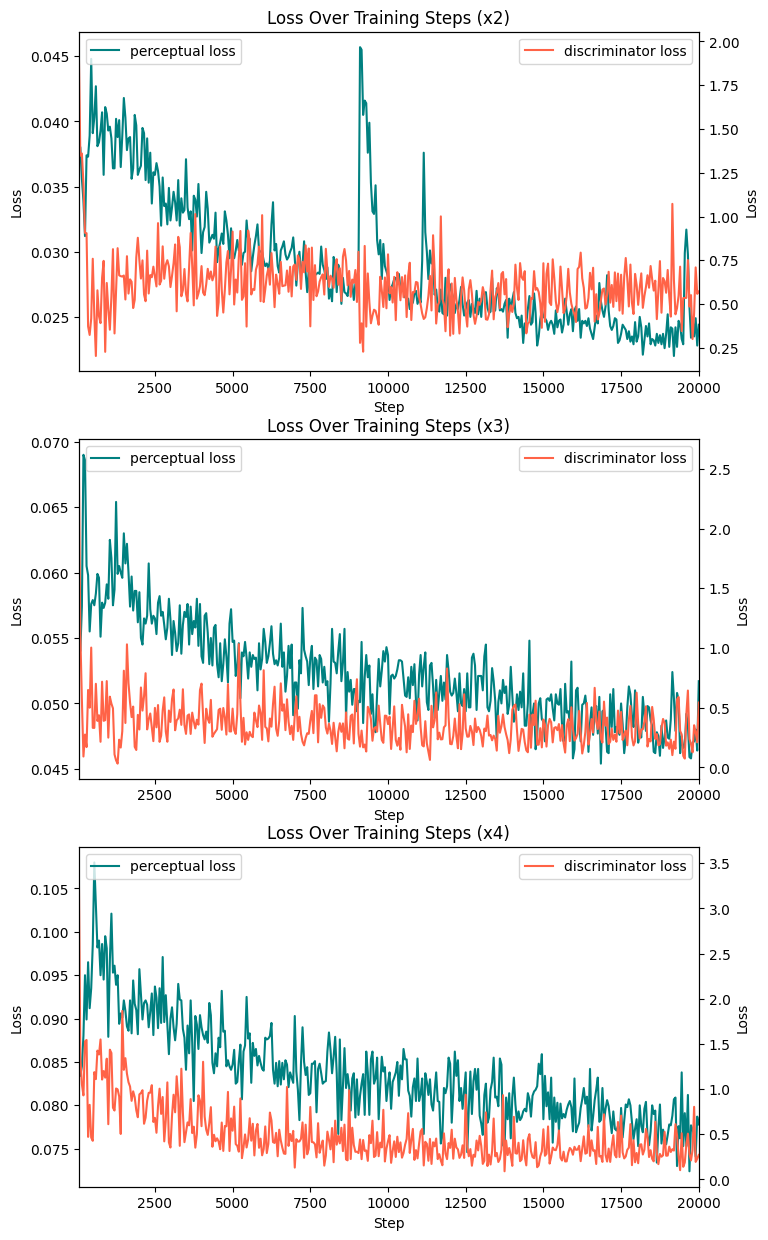

In [32]:
fig = plt.figure(figsize=(8,15))
for i in range(2, 5):
    ax = fig.add_subplot(3, 1, i-1)
    par = ax.twinx()
    log_file = f'results/training_x{i}.log'
    log_lines = read_log_file(log_file)
    results = gan_loss(log_lines)
    p_loss_min = min(results[1])
    d_loss_min = min(results[2])
    ax.plot(results[0], results[1], color='#008080', label=f'perceptual loss')
    # ax.hlines(p_loss_min, xmin=results[0][0], xmax=results[0][-1])
    par.plot(results[0], results[2], color='#FF6347', label=f'discriminator loss')
    # par.hlines(d_loss_min, xmin=results[0][0], xmax=results[0][-1])
    ax.set_xlim(results[0][0], results[0][-1])
    ax.set_xlabel('Step')
    ax.set_ylabel('Loss')
    par.set_ylabel('Loss')
    par.legend(loc='upper right')
    ax.legend(loc='upper left')
    ax.set_title(f"Loss Over Training Steps (x{i})")
fig.savefig('results/training/gan_loss.png')

In [40]:
def random_crop(image, crop_size):
    height, width = image.shape[:2]
    crop_width, crop_height = crop_size

    if width < crop_width or height < crop_height:
        raise ValueError("Crop dimensions are larger than image dimensions")

    x = random.randint(0, width - crop_width)
    y = random.randint(0, height - crop_height)

    cropped_image = image[y:y+crop_height, x:x+crop_width]
    return cropped_image

def random_flip(image, flip_prob=0.5):
    if random.random() < flip_prob:
        return np.fliplr(image)
    return image

def random_rotate(image, angle_range=(-15, 15)):
    angle = random.uniform(angle_range[0], angle_range[1])
    rows, cols = image.shape[:2]
    M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
    return cv2.warpAffine(image, M, (cols, rows))

def apply_random_transforms(image):
    image = random_flip(image)
    image = random_rotate(image)
    image = random_crop(image, (min(image.shape[0], 48), min(image.shape[1], 48)))  # Random crop to a maximum size of 200x200
    return image

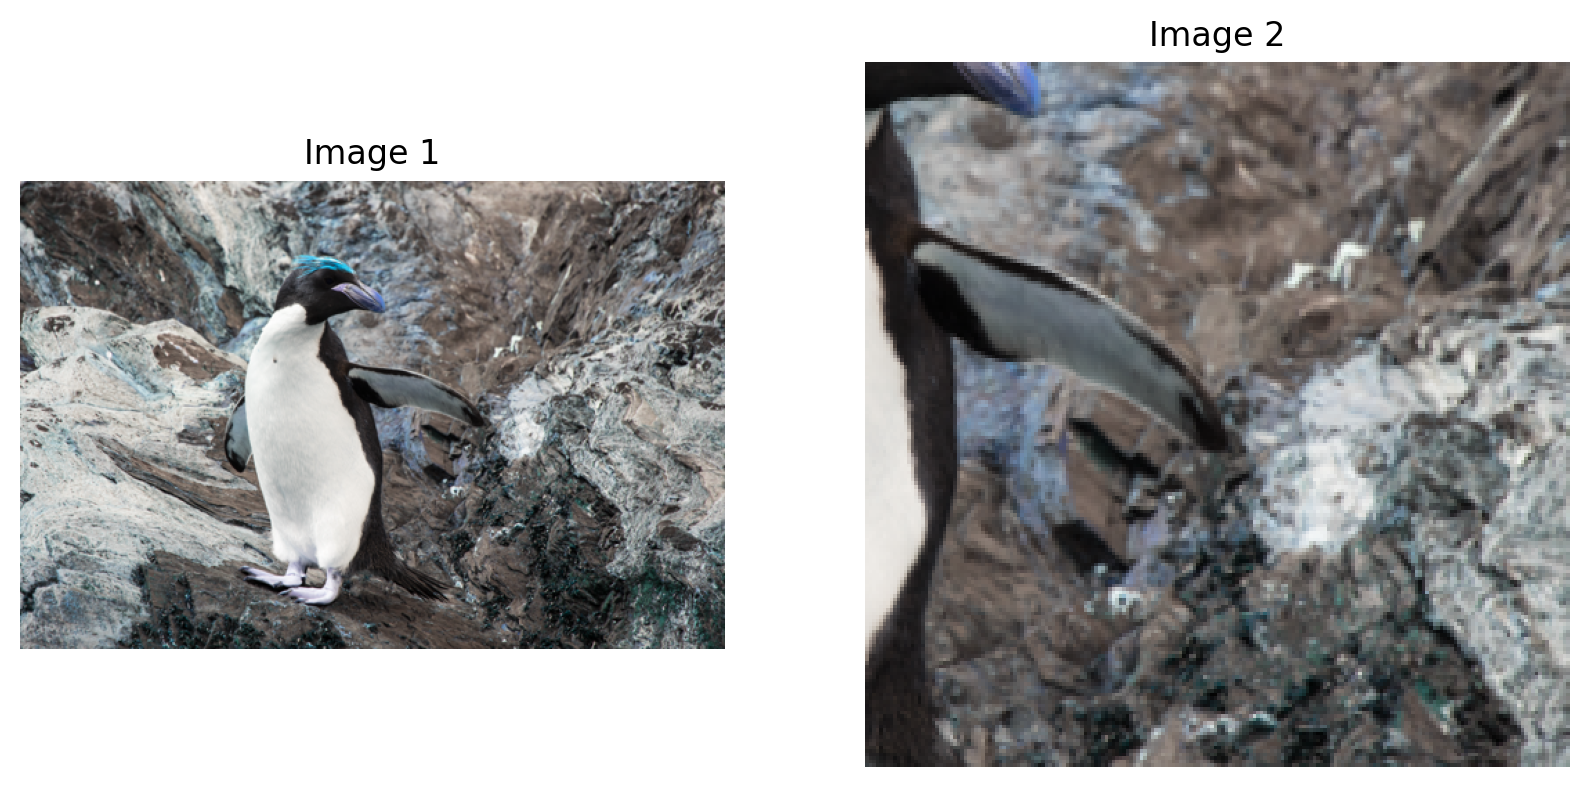

In [57]:
import tensorflow as tf
import cv2 as cv
hr_img = 'dataset/images/DIV2K_valid_HR/0801.png'
lr_x2_img = 'dataset/images/DIV2K_valid_LR_bicubic/X2/0801x2.png'
lr_x3_img = 'dataset/images/DIV2K_valid_LR_bicubic/X3/0801x3.png'
lr_x4_img = 'dataset/images/DIV2K_valid_LR_bicubic/X4/0801x4.png'

fig = plt.figure(figsize=(12, 8))

images = [hr_img, lr_x2_img, lr_x3_img, lr_x4_img]
titles = ['HR', 'LR (x2)', 'LR (x3)', 'LR (x4)']
positions = [1, 2, 3, 4]

for i, (img, title, pos) in enumerate(zip(images, titles, positions)):
    ogsize = 30
    resize = 250
    upper = 50
    left = 50
    upper_r = upper
    left_r = int(left + 1.25 * ogsize)

    bottom = upper + ogsize
    right = left + ogsize
    bottom_r = upper_r + resize
    right_r = left_r + resize


    img_np = img.numpy() if isinstance(img,
                                        tf.Tensor) else img  # Convert to NumPy array if it's a TensorFlow tensor
    part = img_np[upper:bottom, left:right]
    part = part.astype(np.float32)  # Convert to float32
    mask = cv.resize(part, (resize, resize), interpolation=cv.INTER_LINEAR)
    img_np[upper_r:bottom_r, left_r:right_r] = mask
    cv.rectangle(img_np, (left, bottom), (right, upper), (0, 255, 0), thickness=2)
    cv.rectangle(img_np, (left_r, bottom_r), (right_r, upper_r), (0, 255, 0), thickness=2)
    img_np = cv.line(img_np, (right, bottom), (left_r, bottom_r), (0, 255, 0), thickness=2)
    img_np = cv.line(img_np, (right, upper), (left_r, upper_r), (0, 255, 0), thickness=2)
    ax = fig.add_subplot(2, 2, pos)
    ax.imshow(img_np)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
